In [ ]:
# Experiment 4: Fine-tuning Naija-BERT on Nigerian Pidgin Sentiment Dataset (GPU Version)
# This notebook implements the training procedure for the fourth experiment in our cross-lingual sentiment analysis project

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

In [ ]:
import os
import random
import re
!pip install emoji
import emoji
from tqdm.notebook import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 28.6 MB/s eta 0:00:00


In [ ]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# ## 1. Data Preparation

# Function to clean and normalize text
def clean_text(text, is_pidgin=False):
    """
    Clean and normalize text data

    Args:
        text (str): Input text
        is_pidgin (bool): Whether the text is Nigerian Pidgin

    Returns:
        str: Cleaned text
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' [URL] ', text)

    # Remove user mentions (@username)
    text = re.sub(r'@\w+', ' [USER] ', text)

    # Handle hashtags - keep the text but remove the # symbol
    text = re.sub(r'#(\w+)', r'\1', text)

    # Convert emojis to text (alternatively, you can remove them)
    text = emoji.demojize(text)
    text = re.sub(r':[a-z_]+:', ' [EMOJI] ', text)  # replace with token or remove

    # Remove special characters but keep apostrophes (important for contractions)
    text = re.sub(r'[^a-zA-Z0-9\'\s]', ' ', text)

    # Normalize apostrophes
    text = text.replace("'", "'")

    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # For Pidgin-specific normalization
    if is_pidgin:
        # Define common Pidgin expressions to preserve
        pidgin_normalizations = {
            # Common variations
            " de ": " dey ",
            " sey ": " say ",
            " dem ": " them ",
            " una ": " you ",
            " dis ": " this ",
            " dat ": " that ",
            # Common expressions (keep intact)
            "abeg": "abeg",  # please
            "wetin": "wetin",  # what
            "na ": "na ",  # is/it is
            "abi": "abi",  # right?/isn't it?
            "shey": "shey",  # is it that
            "sha": "sha",  # anyway/though
            "wahala": "wahala",  # trouble
            "japa": "japa",  # run away/leave
            "gats": "gats",  # must/have to
        }

        for old, new in pidgin_normalizations.items():
            text = text.replace(old, new)

    return text.strip()

In [ ]:
# Custom dataset class
class SentimentDataset(Dataset):
    """PyTorch dataset for sentiment analysis"""
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Remove the batch dimension which tokenizer adds by default
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding['labels'] = torch.tensor(label)

        return encoding

# Load and prepare datasets
print("Loading datasets...")

Loading datasets...


In [ ]:
# Load Pidgin dataset as the primary training set for Experiment 4
pidgin_df = pd.read_csv('new_annotated_pidgin.csv')
print(f"Pidgin dataset shape: {pidgin_df.shape}")

# Map sentiments to numeric values
sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
pidgin_df['label'] = pidgin_df['Sentiments'].map(sentiment_map)


Pidgin dataset shape: (5000, 2)


In [ ]:
# Clean text
pidgin_df['cleaned_text'] = pidgin_df['Comments'].apply(lambda x: clean_text(x, is_pidgin=True))

In [ ]:
# Check sentiment distribution
sentiment_counts = pidgin_df['Sentiments'].value_counts()
print("\nPidgin sentiment distribution:")
print(sentiment_counts)
print(f"Percentages: {sentiment_counts / len(pidgin_df) * 100}")


Pidgin sentiment distribution:
Sentiments
negative    3099
neutral     1362
positive     539
Name: count, dtype: int64
Percentages: Sentiments
negative    61.98
neutral     27.24
positive    10.78
Name: count, dtype: float64


In [ ]:
# Load English dataset for testing
english_df = pd.read_csv('English_dataset.csv')
print(f"\nEnglish dataset shape: {english_df.shape}")
english_df['label'] = english_df['Sentiments'].map(sentiment_map)
english_df['cleaned_text'] = english_df['text'].apply(lambda x: clean_text(x, is_pidgin=False))


English dataset shape: (10000, 2)


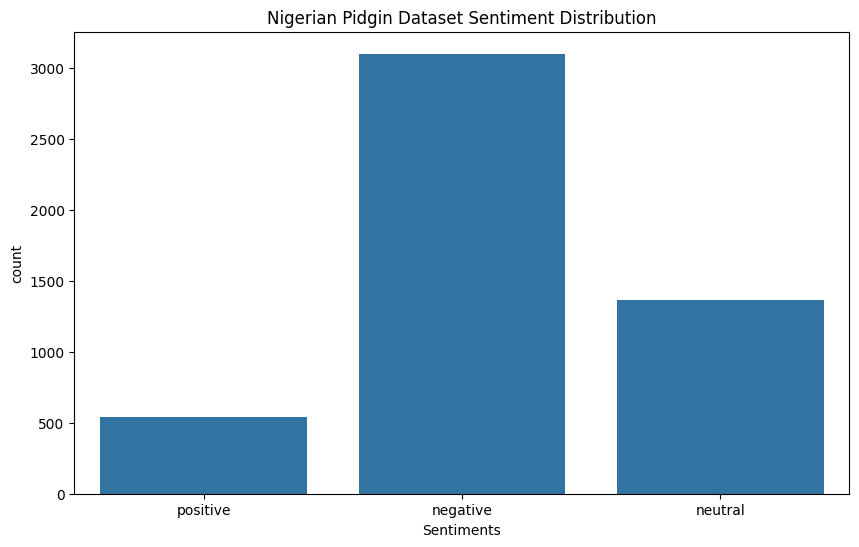

In [ ]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiments', data=pidgin_df)
plt.title('Nigerian Pidgin Dataset Sentiment Distribution')
plt.show()

In [ ]:
# ## 2. Split Datasets

from sklearn.model_selection import train_test_split

# Split into train, validation, and test sets
def split_dataset(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Split dataset into train, validation, and test sets with stratification
    """
    # First split: train + validation and test
    train_val, test = train_test_split(
        df, test_size=test_size, random_state=random_state, stratify=df['label']
    )

    # Second split: train and validation
    # Adjust validation size relative to train_val
    relative_val_size = val_size / (train_size + val_size)
    train, val = train_test_split(
        train_val, test_size=relative_val_size, random_state=random_state,
        stratify=train_val['label']
    )

    return train, val, test

In [ ]:
# Split Pidgin dataset
pidgin_train, pidgin_val, pidgin_test = split_dataset(pidgin_df)

# Display split sizes
print("\nDataset splits:")
print(f"Pidgin - Train: {len(pidgin_train)}, Val: {len(pidgin_val)}, Test: {len(pidgin_test)}")


Dataset splits:
Pidgin - Train: 3500, Val: 750, Test: 750


In [ ]:
# Check class distribution in splits
print("\nTrain distribution:")
print(pidgin_train['Sentiments'].value_counts())
print("\nValidation distribution:")
print(pidgin_val['Sentiments'].value_counts())
print("\nTest distribution:")
print(pidgin_test['Sentiments'].value_counts())


Train distribution:
Sentiments
negative    2169
neutral      954
positive     377
Name: count, dtype: int64

Validation distribution:
Sentiments
negative    465
neutral     204
positive     81
Name: count, dtype: int64

Test distribution:
Sentiments
negative    465
neutral     204
positive     81
Name: count, dtype: int64


In [ ]:
# Sample English test data
english_test = english_df.sample(1500, random_state=42)  # As specified in experiment design
print(f"\nEnglish test set size: {len(english_test)}")
print("English test distribution:")
print(english_test['Sentiments'].value_counts())


English test set size: 1500
English test distribution:
Sentiments
positive    1149
negative     347
neutral        4
Name: count, dtype: int64


In [ ]:
# ## 3. Address Class Imbalance

# Check actual class distribution in Pidgin training data
print("\nChecking for class imbalance in Pidgin training data:")
print(pidgin_train['Sentiments'].value_counts(normalize=True) * 100)

# Compute class weights
def compute_class_weights(labels):
    """Compute class weights inversely proportional to class frequencies"""
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts)

    # Ensure we have weights for all 3 classes
    if len(class_weights) < 3:
        pad_length = 3 - len(class_weights)
        class_weights = np.pad(class_weights, (0, pad_length), 'constant')

    return torch.FloatTensor(class_weights)



Checking for class imbalance in Pidgin training data:
Sentiments
negative    61.971429
neutral     27.257143
positive    10.771429
Name: proportion, dtype: float64


In [ ]:
# Print actual class counts for verification
print("\nActual class counts in training data:")
print(pidgin_train['label'].value_counts().sort_index())


Actual class counts in training data:
label
0     377
1    2169
2     954
Name: count, dtype: int64


In [ ]:
class_weights = compute_class_weights(pidgin_train['label'].values)
print("\nComputed class weights for handling imbalance:")
print(f"Positive (0): {class_weights[0]:.4f}")
print(f"Negative (1): {class_weights[1]:.4f}")
print(f"Neutral (2): {class_weights[2]:.4f}")


Computed class weights for handling imbalance:
Positive (0): 3.0946
Negative (1): 0.5379
Neutral (2): 1.2229


In [ ]:
# ## 4. Initialize Tokenizer

# Initialize the Naija-BERT tokenizer
print("\nInitializing Naija-BERT tokenizer...")
tokenizer = AutoTokenizer.from_pretrained('Davlan/naija-bert-base')

# Determine optimal sequence length
def analyze_token_lengths(texts, tokenizer, percentile=95):
    """Analyze token length distribution and determine max length"""
    token_lengths = []
    for text in tqdm(texts, desc="Analyzing token lengths"):
        if isinstance(text, str) and text.strip():
            tokens = tokenizer.tokenize(text)
            token_lengths.append(len(tokens))

    # Calculate statistics
    mean_len = np.mean(token_lengths)
    median_len = np.median(token_lengths)
    p95 = np.percentile(token_lengths, percentile)
    max_len = np.max(token_lengths)

    # Round up to nearest multiple of 8 for efficiency
    recommended_length = ((int(p95) + 7) // 8) * 8

    print(f"Token length statistics:")
    print(f"Mean: {mean_len:.1f}")
    print(f"Median: {median_len:.1f}")
    print(f"95th percentile: {p95:.1f}")
    print(f"Max: {max_len}")
    print(f"Recommended max_length: {recommended_length}")

    return recommended_length, token_lengths



Initializing Naija-BERT tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/498k [00:00<?, ?B/s]

In [ ]:
# Analyze Pidgin and English token lengths
print("\nAnalyzing Pidgin token lengths with Naija-BERT...")
pidgin_sample = pidgin_train['cleaned_text'].sample(500, random_state=42).tolist()
max_length_pidgin, pidgin_lengths = analyze_token_lengths(pidgin_sample, tokenizer)


Analyzing Pidgin token lengths with Naija-BERT...


Analyzing token lengths:   0%|          | 0/500 [00:00<?, ?it/s]

Token length statistics:
Mean: 39.9
Median: 27.0
95th percentile: 115.2
Max: 414
Recommended max_length: 120


In [ ]:
print("\nAnalyzing English token lengths with Naija-BERT...")
english_sample = english_test['cleaned_text'].sample(500, random_state=42).tolist()
max_length_english, english_lengths = analyze_token_lengths(english_sample, tokenizer)

# Use the maximum of both for test data to handle both languages
max_length_test = max(max_length_english, max_length_pidgin)


Analyzing English token lengths with Naija-BERT...


Analyzing token lengths:   0%|          | 0/500 [00:00<?, ?it/s]

Token length statistics:
Mean: 34.0
Median: 21.0
95th percentile: 102.1
Max: 448
Recommended max_length: 104


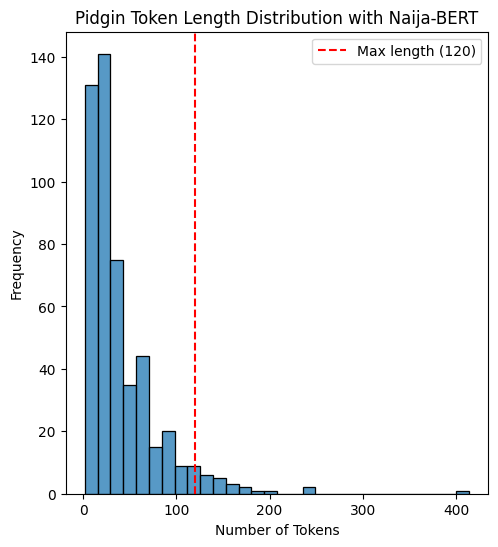

In [ ]:
# Visualize token length distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(pidgin_lengths, bins=30)
plt.axvline(x=max_length_pidgin, color='r', linestyle='--', label=f'Max length ({max_length_pidgin})')
plt.title('Pidgin Token Length Distribution with Naija-BERT')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

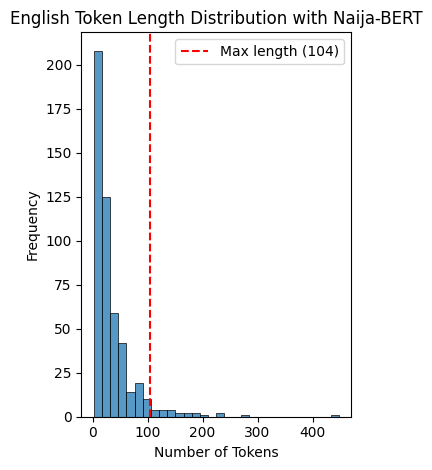

In [ ]:
plt.subplot(1, 2, 2)
sns.histplot(english_lengths, bins=30)
plt.axvline(x=max_length_english, color='r', linestyle='--', label=f'Max length ({max_length_english})')
plt.title('English Token Length Distribution with Naija-BERT')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ## 5. Create PyTorch Datasets

# Prepare datasets
print("Creating PyTorch datasets...")

# Training dataset
train_dataset = SentimentDataset(
    pidgin_train['cleaned_text'].tolist(),
    pidgin_train['label'].tolist(),
    tokenizer,
    max_length=max_length_pidgin
)

# Validation dataset
val_dataset = SentimentDataset(
    pidgin_val['cleaned_text'].tolist(),
    pidgin_val['label'].tolist(),
    tokenizer,
    max_length=max_length_pidgin
)

# Test datasets (separate for Pidgin and English for cross-lingual evaluation)
pidgin_test_dataset = SentimentDataset(
    pidgin_test['cleaned_text'].tolist(),
    pidgin_test['label'].tolist(),
    tokenizer,
    max_length=max_length_test  # Use longer sequence length for test
)

english_test_dataset = SentimentDataset(
    english_test['cleaned_text'].tolist(),
    english_test['label'].tolist(),
    tokenizer,
    max_length=max_length_test  # Use longer sequence length for test
)

# Combined test dataset
combined_test_texts = pidgin_test['cleaned_text'].tolist() + english_test['cleaned_text'].tolist()
combined_test_labels = pidgin_test['label'].tolist() + english_test['label'].tolist()

combined_test_dataset = SentimentDataset(
    combined_test_texts,
    combined_test_labels,
    tokenizer,
    max_length=max_length_test
)


Creating PyTorch datasets...


In [ ]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Pidgin test dataset size: {len(pidgin_test_dataset)}")
print(f"English test dataset size: {len(english_test_dataset)}")
print(f"Combined test dataset size: {len(combined_test_dataset)}")

# Check example batch
train_batch = next(iter(DataLoader(train_dataset, batch_size=2)))
print("\nExample batch keys:", train_batch.keys())
print(f"Input IDs shape: {train_batch['input_ids'].shape}")
print(f"Attention mask shape: {train_batch['attention_mask'].shape}")
print(f"Labels: {train_batch['labels']}")

Train dataset size: 3500
Validation dataset size: 750
Pidgin test dataset size: 750
English test dataset size: 1500
Combined test dataset size: 2250

Example batch keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
Input IDs shape: torch.Size([2, 120])
Attention mask shape: torch.Size([2, 120])
Labels: tensor([1, 1])


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# ## 6. Model Setup and Training

# Define metrics function
def compute_metrics(pred):
    """Compute metrics for evaluation"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [ ]:
# Define weighted trainer that applies class weights during loss computation
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Extract labels
        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply weighted loss
        if self.class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

        # Add labels back to inputs for potential use elsewhere
        inputs["labels"] = labels

        return (loss, outputs) if return_outputs else loss


In [ ]:
# Initialize model
print("\nInitializing Naija-BERT model...")
model = AutoModelForSequenceClassification.from_pretrained(
    'Davlan/naija-bert-base',
    num_labels=3,  # positive, negative, neutral
)


Initializing Naija-BERT model...


pytorch_model.bin:   0%|          | 0.00/562M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Davlan/naija-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Move model to GPU if available
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(70000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Training arguments
print("\nSetting up training arguments...")
training_args = TrainingArguments(
    output_dir="./results/exp4",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs/exp4",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU is available
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Setting up training arguments...


In [ ]:
# Initialize Trainer with early stopping and class weights
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
# ## 7. Train Model

# Train the model
print("\nTraining the model...")
trainer.train()


Training the model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.973800,0.853104,0.613333,0.649770,0.758502,0.613333
2,0.674800,0.580676,0.792000,0.805067,0.841535,0.792000
3,0.576700,0.868483,0.828000,0.821316,0.825611,0.828000
4,0.441300,0.776046,0.849333,0.844259,0.846467,0.849333
5,0.165700,0.770463,0.870667,0.868815,0.869422,0.870667


TrainOutput(global_step=1095, training_loss=0.5511655223968367, metrics={'train_runtime': 177.2486, 'train_samples_per_second': 98.731, 'train_steps_per_second': 6.178, 'total_flos': 1079176127400000.0, 'train_loss': 0.5511655223968367, 'epoch': 5.0})

In [ ]:
# Save the final model
print("\nSaving the best model...")
trainer.save_model("./results/exp4/best_model")
tokenizer.save_pretrained("./results/exp4/tokenizer")


Saving the best model...


('./results/exp4/tokenizer/tokenizer_config.json',
 './results/exp4/tokenizer/special_tokens_map.json',
 './results/exp4/tokenizer/vocab.txt',
 './results/exp4/tokenizer/added_tokens.json',
 './results/exp4/tokenizer/tokenizer.json')

In [ ]:
# ## 8. Evaluation

# Evaluate on validation set
print("\nEvaluating on validation set...")
val_results = trainer.evaluate(val_dataset)
print(f"Validation results: {val_results}")

# Evaluate on Pidgin test set
print("\nEvaluating on Pidgin test set (in-language performance)...")
pidgin_test_results = trainer.evaluate(pidgin_test_dataset)
print(f"Pidgin test results: {pidgin_test_results}")

# Evaluate on English test set
print("\nEvaluating on English test set (cross-lingual performance)...")
english_test_results = trainer.evaluate(english_test_dataset)
print(f"English test results: {english_test_results}")

# Evaluate on combined test set
print("\nEvaluating on combined test set...")
combined_test_results = trainer.evaluate(combined_test_dataset)
print(f"Combined test results: {combined_test_results}")


Evaluating on validation set...


Validation results: {'eval_loss': 0.7704634070396423, 'eval_accuracy': 0.8706666666666667, 'eval_f1': 0.8688146075198253, 'eval_precision': 0.8694220510138397, 'eval_recall': 0.8706666666666667, 'eval_runtime': 1.3983, 'eval_samples_per_second': 536.374, 'eval_steps_per_second': 17.164, 'epoch': 5.0}

Evaluating on Pidgin test set (in-language performance)...
Pidgin test results: {'eval_loss': 0.8588423132896423, 'eval_accuracy': 0.8506666666666667, 'eval_f1': 0.8497255929510116, 'eval_precision': 0.8493825348472261, 'eval_recall': 0.8506666666666667, 'eval_runtime': 1.3104, 'eval_samples_per_second': 572.324, 'eval_steps_per_second': 18.314, 'epoch': 5.0}

Evaluating on English test set (cross-lingual performance)...
English test results: {'eval_loss': 1.5905932188034058, 'eval_accuracy': 0.562, 'eval_f1': 0.6721788909175321, 'eval_precision': 0.8495637421599205, 'eval_recall': 0.562, 'eval_runtime': 2.6044, 'eval_samples_per_second': 575.949, 'eval_steps_per_second': 18.046, 'epoch':

In [ ]:
# ## 9. Detailed Performance Analysis

# Get predictions for the test sets
def get_predictions(model, dataset, device):
    """Get model predictions for a dataset"""
    dataloader = DataLoader(dataset, batch_size=16)
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**{k: v for k, v in batch.items() if k != 'labels'})

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [ ]:
# Get predictions
pidgin_preds, pidgin_labels = get_predictions(model, pidgin_test_dataset, device)
english_preds, english_labels = get_predictions(model, english_test_dataset, device)

Getting predictions:   0%|          | 0/47 [00:00<?, ?it/s]

Getting predictions:   0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
# Detailed metrics
def print_detailed_metrics(preds, labels, dataset_name):
    """Print detailed metrics for a dataset"""
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    print(f"\n{dataset_name} Detailed Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")

    # Classification report
    label_names = ['positive', 'negative', 'neutral']
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=label_names))

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



Pidgin Test Detailed Metrics:
Accuracy: 0.8507
F1 Score (weighted): 0.8497
Precision (weighted): 0.8494
Recall (weighted): 0.8507

Classification Report:
              precision    recall  f1-score   support

    positive       0.75      0.67      0.71        81
    negative       0.91      0.92      0.91       465
     neutral       0.75      0.76      0.76       204

    accuracy                           0.85       750
   macro avg       0.80      0.78      0.79       750
weighted avg       0.85      0.85      0.85       750



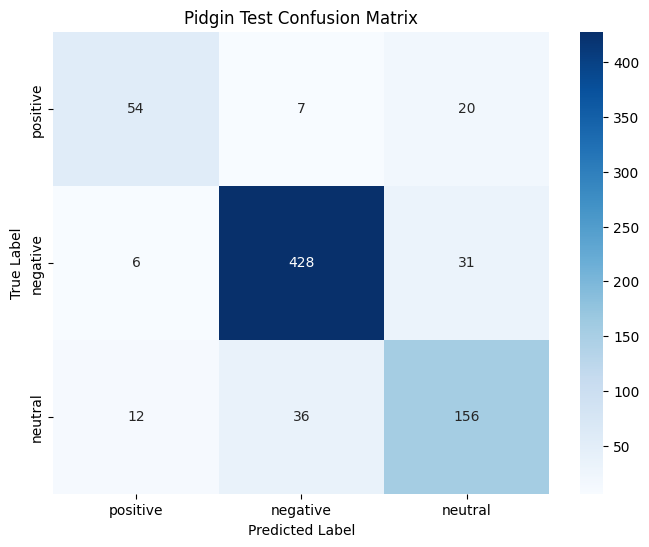


English Test (Cross-lingual) Detailed Metrics:
Accuracy: 0.5620
F1 Score (weighted): 0.6722
Precision (weighted): 0.8496
Recall (weighted): 0.5620

Classification Report:
              precision    recall  f1-score   support

    positive       0.93      0.65      0.76      1149
    negative       0.60      0.28      0.38       347
     neutral       0.01      0.75      0.01         4

    accuracy                           0.56      1500
   macro avg       0.51      0.56      0.39      1500
weighted avg       0.85      0.56      0.67      1500



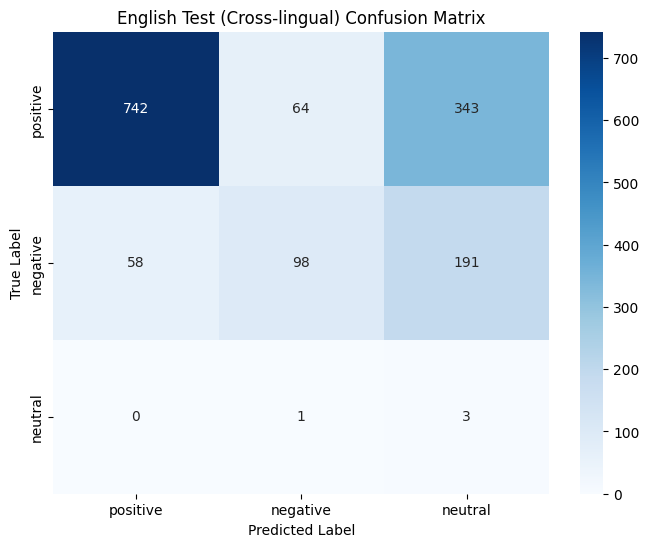

In [ ]:
# Print detailed metrics
print_detailed_metrics(pidgin_preds, pidgin_labels, "Pidgin Test")
print_detailed_metrics(english_preds, english_labels, "English Test (Cross-lingual)")

In [ ]:
# ## 10. Analyze Error Cases

# Function to analyze error cases
def analyze_errors(texts, preds, labels, dataset_name, max_examples=10):
    """Analyze and display error cases"""
    errors = []
    for i in range(len(texts)):
        if preds[i] != labels[i]:
            errors.append({
                'text': texts[i],
                'true_label': labels[i],
                'pred_label': preds[i]
            })

    print(f"\n{dataset_name} Error Analysis ({len(errors)} errors out of {len(texts)} samples):")
    print(f"Error rate: {len(errors)/len(texts):.2%}")

    # Group errors by type
    error_types = {}
    for error in errors:
        key = f"{error['true_label']} -> {error['pred_label']}"
        if key not in error_types:
            error_types[key] = []
        error_types[key].append(error)

    # Print error distribution
    print("\nError distribution:")
    for error_type, examples in error_types.items():
        true_label, pred_label = error_type.split(' -> ')
        label_map_inv = {0: 'positive', 1: 'negative', 2: 'neutral'}
        true_name = label_map_inv[int(true_label)]
        pred_name = label_map_inv[int(pred_label)]
        print(f"  {true_name} predicted as {pred_name}: {len(examples)} cases ({len(examples)/len(errors):.2%} of errors)")

    # Show examples of each error type
    print("\nExample errors by type:")
    for error_type, examples in error_types.items():
        true_label, pred_label = error_type.split(' -> ')
        label_map_inv = {0: 'positive', 1: 'negative', 2: 'neutral'}
        true_name = label_map_inv[int(true_label)]
        pred_name = label_map_inv[int(pred_label)]

        print(f"\n{true_name} predicted as {pred_name}:")
        for i, error in enumerate(examples[:max_examples]):
            print(f"  Example {i+1}: {error['text']}")


In [ ]:
# Analyze Pidgin errors
analyze_errors(
    pidgin_test['cleaned_text'].tolist(),
    pidgin_preds,
    pidgin_labels,
    "Pidgin Test"
)


Pidgin Test Error Analysis (112 errors out of 750 samples):
Error rate: 14.93%

Error distribution:
  positive predicted as negative: 7 cases (6.25% of errors)
  neutral predicted as negative: 36 cases (32.14% of errors)
  negative predicted as neutral: 31 cases (27.68% of errors)
  negative predicted as positive: 6 cases (5.36% of errors)
  positive predicted as neutral: 20 cases (17.86% of errors)
  neutral predicted as positive: 12 cases (10.71% of errors)

Example errors by type:

positive predicted as negative:
  Example 1: awesome news kudos to oga jide bia na only lagos dey this country the remaining 35 states wetin dey sup i know you can't match lagos developmentally but some of you no just dey try at all not even to fix potholes
  Example 2: 1 you mean kind of like how oyinbo dey wear bathing suit dey swim with their kids while africans feel they need to cover it all up in the name of modesty yet their children are just as hypersexualized from a young age 2 i have to disagree

In [ ]:
# Analyze English errors
analyze_errors(
    english_test['cleaned_text'].tolist(),
    english_preds,
    english_labels,
    "English Test"
)



English Test Error Analysis (657 errors out of 1500 samples):
Error rate: 43.80%

Error distribution:
  positive predicted as neutral: 343 cases (52.21% of errors)
  positive predicted as negative: 64 cases (9.74% of errors)
  negative predicted as neutral: 191 cases (29.07% of errors)
  negative predicted as positive: 58 cases (8.83% of errors)
  neutral predicted as negative: 1 cases (0.15% of errors)

Example errors by type:

positive predicted as neutral:
  Example 1: we liked everything about the product it was devoured quickly at the christmas even smorgasbord
  Example 2: this is good honey it has a good strong flavor i am not one who likes a mild honey and i always prefer a raw unfiltered honey this is delicious and i will buy again
  Example 3: these had an odd taste to them kind of like when you leave a food item close to another in the fridge and it absorbs the flavor of something closeby i had intended to keep this item on a subscription but due to the odd taste i ve cance

In [ ]:
# ## 11. Compare Performance Across Languages

# Plot comparison of in-language (Pidgin) vs cross-lingual (English) performance
def plot_performance_comparison(pidgin_metrics, english_metrics):
    """Plot performance comparison between languages"""
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    pidgin_scores = [pidgin_metrics[f'eval_{m}'] for m in metrics]
    english_scores = [english_metrics[f'eval_{m}'] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, pidgin_scores, width, label='Pidgin (In-language)')
    rects2 = ax.bar(x + width/2, english_scores, width, label='English (Cross-lingual)')

    ax.set_ylabel('Score')
    ax.set_title('Performance Comparison: Pidgin vs. English')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Add value labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

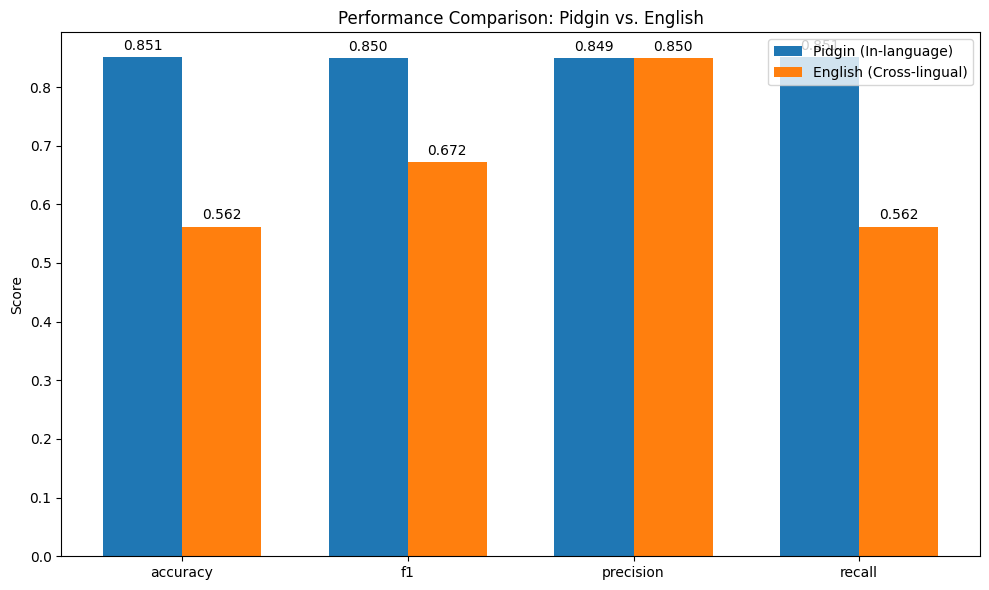

In [ ]:
# Plot performance comparison
plot_performance_comparison(pidgin_test_results, english_test_results)


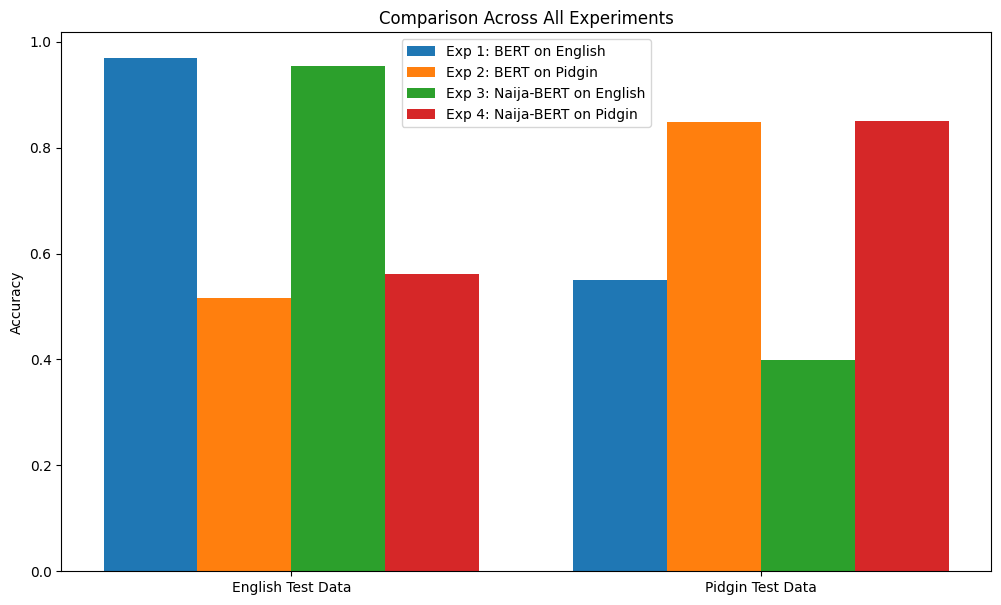

In [ ]:
# ## 12. Compare to Previous Experiments

# Previous experiment results
exp1_english_accuracy = 0.9693  # From Experiment 1 results
exp1_pidgin_accuracy = 0.5493   # From Experiment 1 results
exp2_english_accuracy = 0.516   # From Experiment 2 results
exp2_pidgin_accuracy = 0.848    # From Experiment 2 results
exp3_english_accuracy = 0.9533  # From Experiment 3 results
exp3_pidgin_accuracy = 0.3987   # From Experiment 3 results
exp4_english_accuracy = english_test_results['eval_accuracy']
exp4_pidgin_accuracy = pidgin_test_results['eval_accuracy']

# Create comparison chart for all experiments
labels = ['English Test Data', 'Pidgin Test Data']
exp1_scores = [exp1_english_accuracy, exp1_pidgin_accuracy]
exp2_scores = [exp2_english_accuracy, exp2_pidgin_accuracy]
exp3_scores = [exp3_english_accuracy, exp3_pidgin_accuracy]
exp4_scores = [exp4_english_accuracy, exp4_pidgin_accuracy]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - 1.5*width, exp1_scores, width, label='Exp 1: BERT on English')
rects2 = ax.bar(x - 0.5*width, exp2_scores, width, label='Exp 2: BERT on Pidgin')
rects3 = ax.bar(x + 0.5*width, exp3_scores, width, label='Exp 3: Naija-BERT on English')
rects4 = ax.bar(x + 1.5*width, exp4_scores, width, label='Exp 4: Naija-BERT on Pidgin')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison Across All Experiments')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


In [ ]:
# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()

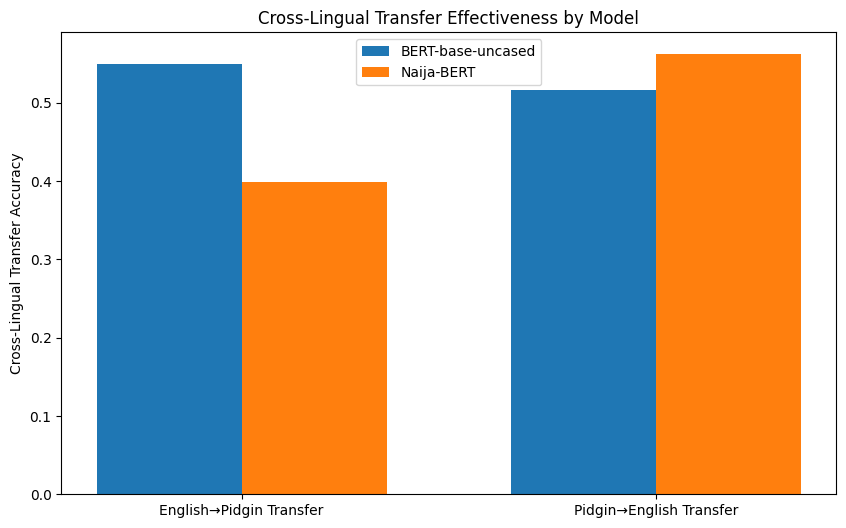

In [ ]:
# Cross-Lingual Transfer Analysis
transfer_labels = ['English→Pidgin Transfer', 'Pidgin→English Transfer']
bert_transfer = [exp1_pidgin_accuracy, exp2_english_accuracy]  # BERT
naija_transfer = [exp3_pidgin_accuracy, exp4_english_accuracy]  # Naija-BERT

x = np.arange(len(transfer_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, bert_transfer, width, label='BERT-base-uncased')
rects2 = ax.bar(x + width/2, naija_transfer, width, label='Naija-BERT')

ax.set_ylabel('Cross-Lingual Transfer Accuracy')
ax.set_title('Cross-Lingual Transfer Effectiveness by Model')
ax.set_xticks(x)
ax.set_xticklabels(transfer_labels)
ax.legend()

In [ ]:
# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

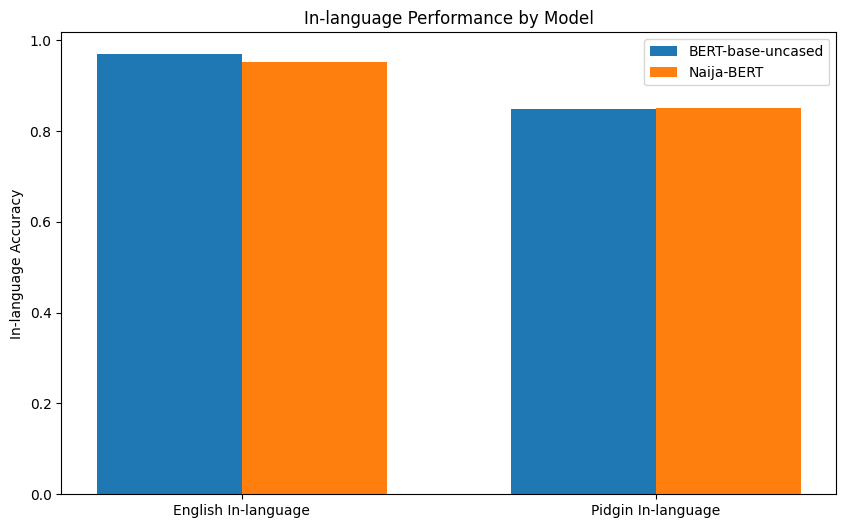

In [ ]:
# In-language Performance Analysis
in_language_labels = ['English In-language', 'Pidgin In-language']
bert_in_language = [exp1_english_accuracy, exp2_pidgin_accuracy]  # BERT
naija_in_language = [exp3_english_accuracy, exp4_pidgin_accuracy]  # Naija-BERT

x = np.arange(len(in_language_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, bert_in_language, width, label='BERT-base-uncased')
rects2 = ax.bar(x + width/2, naija_in_language, width, label='Naija-BERT')

ax.set_ylabel('In-language Accuracy')
ax.set_title('In-language Performance by Model')
ax.set_xticks(x)
ax.set_xticklabels(in_language_labels)
ax.legend()

In [ ]:
# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

Comprehensive Results Across All Experiments:
                   Model  English Accuracy  Pidgin Accuracy  In-language  \
0        BERT on English            0.9693         0.549300     0.969300   
1         BERT on Pidgin            0.5160         0.848000     0.848000   
2  Naija-BERT on English            0.9533         0.398700     0.953300   
3   Naija-BERT on Pidgin            0.5620         0.850667     0.850667   

   Cross-lingual  Transfer Gap  
0         0.5493      0.420000  
1         0.5160      0.332000  
2         0.3987      0.554600  
3         0.5620      0.288667  


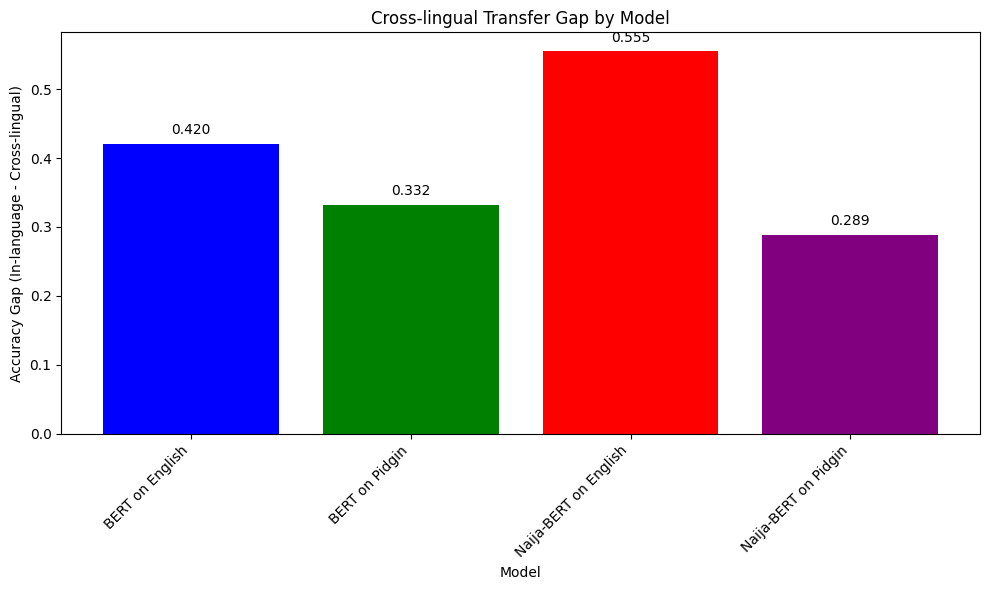

In [ ]:
# ## 13. Comprehensive Analysis Across All Experiments

# Create a table of all results
results_table = pd.DataFrame({
    'Model': ['BERT on English', 'BERT on Pidgin', 'Naija-BERT on English', 'Naija-BERT on Pidgin'],
    'English Accuracy': [exp1_english_accuracy, exp2_english_accuracy, exp3_english_accuracy, exp4_english_accuracy],
    'Pidgin Accuracy': [exp1_pidgin_accuracy, exp2_pidgin_accuracy, exp3_pidgin_accuracy, exp4_pidgin_accuracy]
})

# Calculate cross-lingual transfer gap
results_table['In-language'] = [results_table.loc[0, 'English Accuracy'],
                               results_table.loc[1, 'Pidgin Accuracy'],
                               results_table.loc[2, 'English Accuracy'],
                               results_table.loc[3, 'Pidgin Accuracy']]

results_table['Cross-lingual'] = [results_table.loc[0, 'Pidgin Accuracy'],
                                 results_table.loc[1, 'English Accuracy'],
                                 results_table.loc[2, 'Pidgin Accuracy'],
                                 results_table.loc[3, 'English Accuracy']]

results_table['Transfer Gap'] = results_table['In-language'] - results_table['Cross-lingual']

print("Comprehensive Results Across All Experiments:")
print(results_table[['Model', 'English Accuracy', 'Pidgin Accuracy', 'In-language', 'Cross-lingual', 'Transfer Gap']])

# Visualize the transfer gap
plt.figure(figsize=(10, 6))
bars = plt.bar(results_table['Model'], results_table['Transfer Gap'], color=['blue', 'green', 'red', 'purple'])

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')

plt.title('Cross-lingual Transfer Gap by Model')
plt.ylabel('Accuracy Gap (In-language - Cross-lingual)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# ## 14. Save Results and Summary

# Create output directory if it doesn't exist
os.makedirs("./results/exp4", exist_ok=True)

# Save all results
results_summary = {
    'validation': val_results,
    'pidgin_test': pidgin_test_results,
    'english_test': english_test_results,
    'combined_test': combined_test_results
}


In [ ]:
# Write results to file
with open("./results/exp4/results_summary.txt", "w") as f:
    f.write("Experiment 4: Naija-BERT fine-tuned on Nigerian Pidgin\n")
    f.write("=============================================\n\n")

    f.write("Model: Davlan/naija-bert-base with class weights\n")
    f.write(f"Train dataset size: {len(train_dataset)}\n")
    f.write(f"Validation dataset size: {len(val_dataset)}\n")
    f.write(f"Pidgin test dataset size: {len(pidgin_test_dataset)}\n")
    f.write(f"English test dataset size: {len(english_test_dataset)}\n")
    f.write(f"Combined test dataset size: {len(combined_test_dataset)}\n\n")

    f.write("Results:\n")
    for dataset_name, results in results_summary.items():
        f.write(f"\n{dataset_name.upper()} RESULTS:\n")
        for metric, value in results.items():
            f.write(f"  {metric}: {value}\n")

    # Compare with previous experiments
    f.write("\nCOMPARISON WITH ALL EXPERIMENTS:\n")
    f.write(f"  Exp1 (BERT on English) - English: {exp1_english_accuracy:.4f}, Pidgin: {exp1_pidgin_accuracy:.4f}\n")
    f.write(f"  Exp2 (BERT on Pidgin) - English: {exp2_english_accuracy:.4f}, Pidgin: {exp2_pidgin_accuracy:.4f}\n")
    f.write(f"  Exp3 (Naija-BERT on English) - English: {exp3_english_accuracy:.4f}, Pidgin: {exp3_pidgin_accuracy:.4f}\n")
    f.write(f"  Exp4 (Naija-BERT on Pidgin) - English: {exp4_english_accuracy:.4f}, Pidgin: {exp4_pidgin_accuracy:.4f}\n\n")

    # Add table
    f.write("COMPREHENSIVE RESULTS TABLE:\n")
    f.write(results_table.to_string(index=False))

print("\nExperiment completed! Results saved to ./results/exp4/results_summary.txt")


Experiment completed! Results saved to ./results/exp4/results_summary.txt


In [ ]:
# ## 15. Final Observations

print("\nFinal Observations:")
print("1. In-language Performance:")
print(f"   - BERT on English: {exp1_english_accuracy:.4f}")
print(f"   - BERT on Pidgin: {exp2_pidgin_accuracy:.4f}")
print(f"   - Naija-BERT on English: {exp3_english_accuracy:.4f}")
print(f"   - Naija-BERT on Pidgin: {exp4_pidgin_accuracy:.4f}")



Final Observations:
1. In-language Performance:
   - BERT on English: 0.9693
   - BERT on Pidgin: 0.8480
   - Naija-BERT on English: 0.9533
   - Naija-BERT on Pidgin: 0.8507


In [ ]:
print("\n2. Cross-lingual Transfer:")
print(f"   - English to Pidgin (BERT): {exp1_pidgin_accuracy:.4f}")
print(f"   - Pidgin to English (BERT): {exp2_english_accuracy:.4f}")
print(f"   - English to Pidgin (Naija-BERT): {exp3_pidgin_accuracy:.4f}")
print(f"   - Pidgin to English (Naija-BERT): {exp4_english_accuracy:.4f}")



2. Cross-lingual Transfer:
   - English to Pidgin (BERT): 0.5493
   - Pidgin to English (BERT): 0.5160
   - English to Pidgin (Naija-BERT): 0.3987
   - Pidgin to English (Naija-BERT): 0.5620


In [ ]:
print("\n3. Transfer Gaps:")
best_model_idx = results_table['Transfer Gap'].idxmin()
best_model = results_table.loc[best_model_idx, 'Model']
best_gap = results_table.loc[best_model_idx, 'Transfer Gap']



3. Transfer Gaps:


In [ ]:
print(f"   - BERT (English→Pidgin): {exp1_english_accuracy - exp1_pidgin_accuracy:.4f}")
print(f"   - BERT (Pidgin→English): {exp2_pidgin_accuracy - exp2_english_accuracy:.4f}")
print(f"   - Naija-BERT (English→Pidgin): {exp3_english_accuracy - exp3_pidgin_accuracy:.4f}")
print(f"   - Naija-BERT (Pidgin→English): {exp4_pidgin_accuracy - exp4_english_accuracy:.4f}")
print(f"   - Best model for cross-lingual transfer: {best_model} (Gap: {best_gap:.4f})")

   - BERT (English→Pidgin): 0.4200
   - BERT (Pidgin→English): 0.3320
   - Naija-BERT (English→Pidgin): 0.5546
   - Naija-BERT (Pidgin→English): 0.2887
   - Best model for cross-lingual transfer: Naija-BERT on Pidgin (Gap: 0.2887)


In [ ]:
# Check which model has the best cross-lingual performance in each direction
best_eng_to_pidgin = max(exp1_pidgin_accuracy, exp3_pidgin_accuracy)
best_pidgin_to_eng = max(exp2_english_accuracy, exp4_english_accuracy)

print("\n4. Best Cross-lingual Models:")
print(f"   - English to Pidgin: {'BERT' if best_eng_to_pidgin == exp1_pidgin_accuracy else 'Naija-BERT'} ({best_eng_to_pidgin:.4f})")
print(f"   - Pidgin to English: {'BERT' if best_pidgin_to_eng == exp2_english_accuracy else 'Naija-BERT'} ({best_pidgin_to_eng:.4f})")


4. Best Cross-lingual Models:
   - English to Pidgin: BERT (0.5493)
   - Pidgin to English: Naija-BERT (0.5620)


In [ ]:
print("\n5. Overall Best Model for Sentiment Analysis:")
# Calculate average performance across both languages
avg_performance = results_table[['English Accuracy', 'Pidgin Accuracy']].mean(axis=1)
best_avg_idx = avg_performance.idxmax()
best_avg_model = results_table.loc[best_avg_idx, 'Model']
print(f"   - Best overall model: {best_avg_model} (Avg. Accuracy: {avg_performance[best_avg_idx]:.4f})")



5. Overall Best Model for Sentiment Analysis:
   - Best overall model: BERT on English (Avg. Accuracy: 0.7593)
